# k-means clustering demo in 2D
2018 Winter Term 1

By Mike Gelbart (converted to Julia by Jason Chau)

In [37]:
using PyCall,PyPlot
plt = pyimport("matplotlib.pyplot")

function plot_clust(X,W=nothing,z=nothing)
    if z != nothing
        if any(z.<0)
            plt.scatter(X[z.<0,1], X[z.<0,2], marker="o", 
                        facecolors="none", edgecolor="black", alpha=0.3);
        end
        if any(z.>=0)
            plt.scatter(X[z.>=0,1], X[z.>=0,2], marker="o", c=z[z.>=0], alpha=0.3);
        end
    else
        plt.scatter(X[:,1], X[:,2], marker="o", c="black", alpha=0.3);
    end
    if W != nothing
        plt.scatter(W[:,1], W[:,2], marker="^", s=200, c=1:size(W)[1]);
    else
        len = length(filter(!isequal(-1),unique(z)))
        plt.title("number of clusters = $len");
    end
end

plot_clust (generic function with 3 methods)

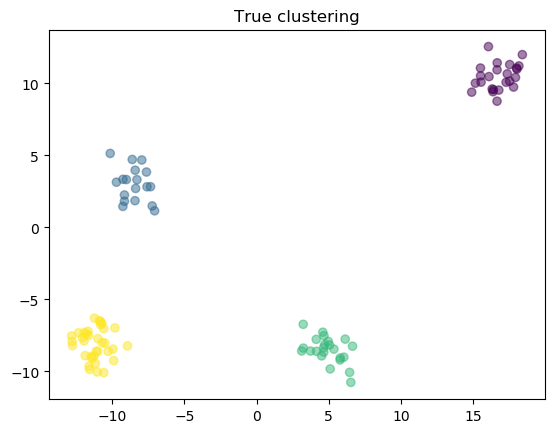

In [32]:
# make up some fake data
using Random

Random.seed!(24) 
# above: it's fine to delete this, but you might have to
# re-run things a few times to see the effects of interest

n = 100
d = 2
k_true = 4
W_true = randn(k_true,d).*10
z_true = rand(1:k_true,n)
X = zeros(n,2)
for i in 1:n
    X[i,:] = W_true[z_true[i],:] .+ randn(d)
end

plt.scatter(X[:,1], X[:,2], c=z_true, marker="o", alpha=0.5);
plt.title("True clustering");

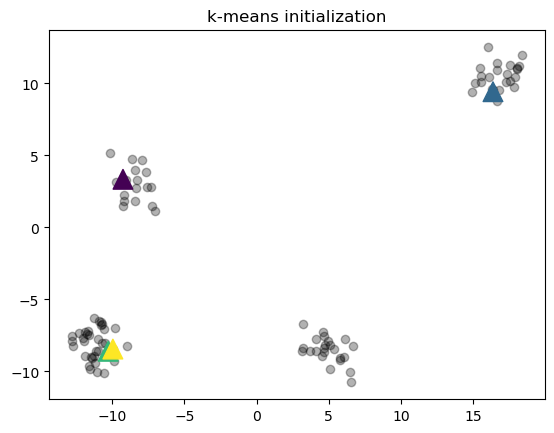

In [38]:
# randomly initialize means

k = 4
W = X[randperm(n)[1:k],:]

plot_clust(X,W)
plt.title("k-means initialization");

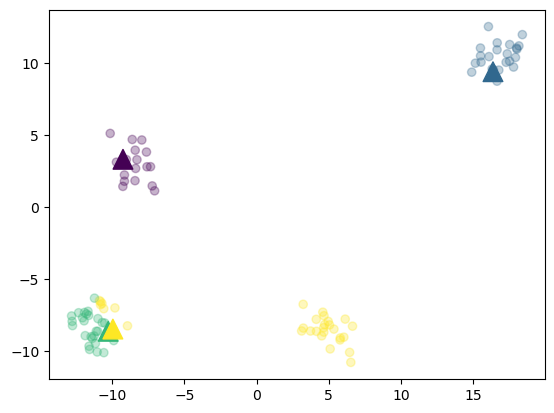

PyObject <matplotlib.collections.PathCollection object at 0x000000002AAE2C88>

In [39]:
# assign each object to closest mean
SkMetricsPairwise = pyimport("sklearn.metrics.pairwise")

function update_z(X,W)
    dist2 = SkMetricsPairwise.euclidean_distances(X, W)
    return [argmin(dist2[i,:]) for i in 1:size(dist2)[1]]
end

z = update_z(X,W)
plot_clust(X,W,z)

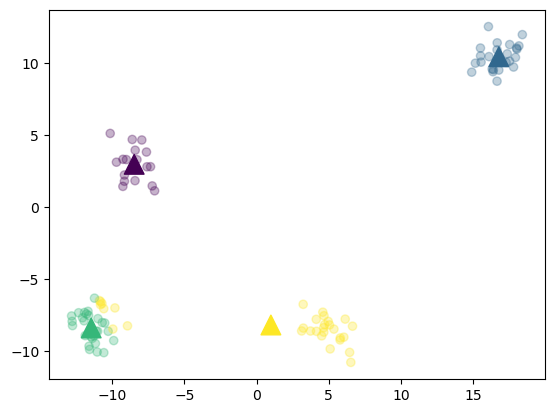

PyObject <matplotlib.collections.PathCollection object at 0x000000002AC99EB8>

In [43]:
# recompute cluster centres
using Statistics

function update_W(X,z,W_old)
    # just being a bit careful about the case of a cluster with no points in it
    W = W_old
    for kk in 1:k
        W[kk,:] = [Statistics.mean(X[z.==kk,i]) for i in 1:size(X)[2]]
    end
    return W
end
        

W = update_W(X,z,W)
plot_clust(X,W,z)

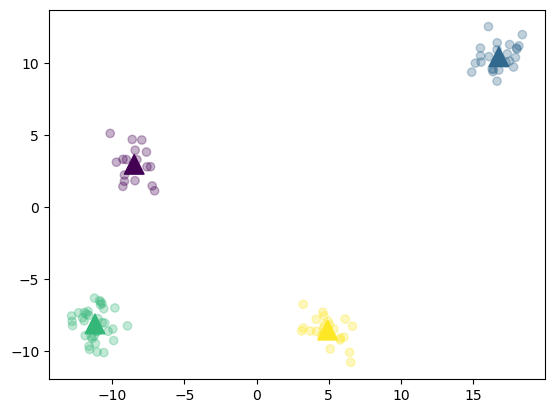

PyObject <matplotlib.collections.PathCollection object at 0x0000000032B7EE48>

In [44]:
# run the whole thing for 100 iterations
# better: loop until np.all(z_new == z)
for itr in 1:100
    z = update_z(X,W)
    W = update_W(X,z,W)
end
plot_clust(X,W,z)

In [45]:
W

4×2 Array{Float64,2}:
  -8.47881   2.99699
  16.7872   10.4637 
 -11.1959   -8.08447
   4.92725  -8.51555

In [46]:
z

100-element Array{Int64,1}:
 3
 2
 4
 4
 3
 3
 3
 2
 3
 3
 4
 4
 2
 ⋮
 1
 1
 2
 2
 3
 2
 4
 4
 4
 1
 3
 2

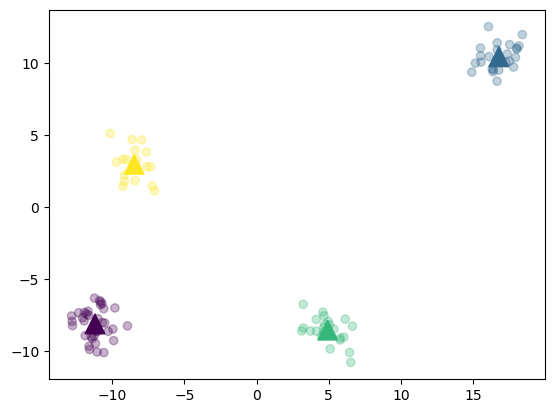

PyObject <matplotlib.collections.PathCollection object at 0x0000000031AAE5C0>

In [47]:
# compare to sklearn kmeans
SkCluster = pyimport("sklearn.cluster")

kmeans = SkCluster.KMeans(n_clusters=k)
kmeans.fit(X)
plot_clust(X,kmeans.cluster_centers_, kmeans.labels_)

Note the label switching.

Comparing different initializations:

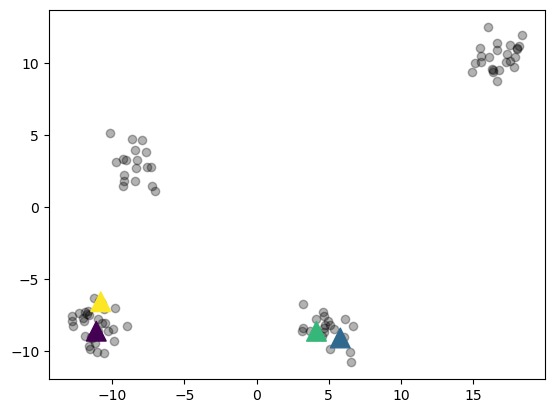

PyObject <matplotlib.collections.PathCollection object at 0x0000000041FFE588>

In [48]:
# pick a different initialization and re-run
Random.seed!(1)

W = X[randperm(n)[1:k],:]
plot_clust(X,W)

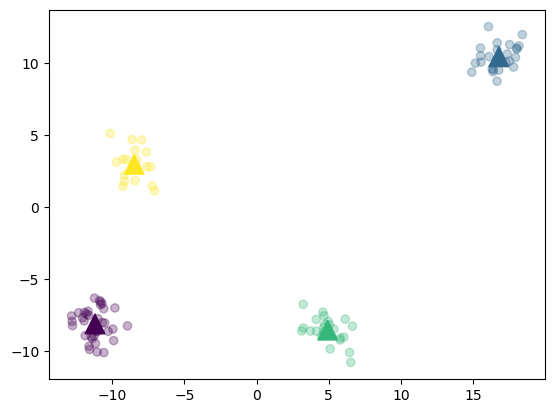

PyObject <matplotlib.collections.PathCollection object at 0x0000000041EA7128>

In [49]:
for itr in 1:100
    z = update_z(X,W)
    W = update_W(X,z,W)
end
    
plot_clust(X,W,z)

# Vector quantization demo

In [127]:
function quantize(img, bpp)
    H, W, _ = size(img)
    X = reshape(img,H*W,3)
    
    model = SkCluster.KMeans(n_clusters=2^bpp, n_init=3)
    quantized_img = reshape(model.fit_predict(X),H,W)
    colours = broadcast(UInt,broadcast(floor,model.cluster_centers_))

    return quantized_img, colours
end

function dequantize(quantized_img, colours)
    H, W = size(quantized_img)
    img = zeros(UInt8,H,W,3)

    for i in 1:H
        for j in 1:W
            img[i,j,:] = colours[quantized_img[i,j]+1,:]
        end
    end

    return img
end

dequantize (generic function with 1 method)

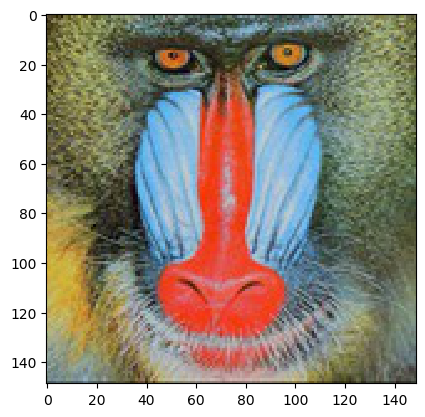

In [90]:
# using Conda
# Conda.add("scikit-image")
# SkImage = pyimport("skimage.io")
# os = pyimport("os")

img = SkImage.imread(os.path.join("img", "mandrill.jpg"))
plt.imshow(img);

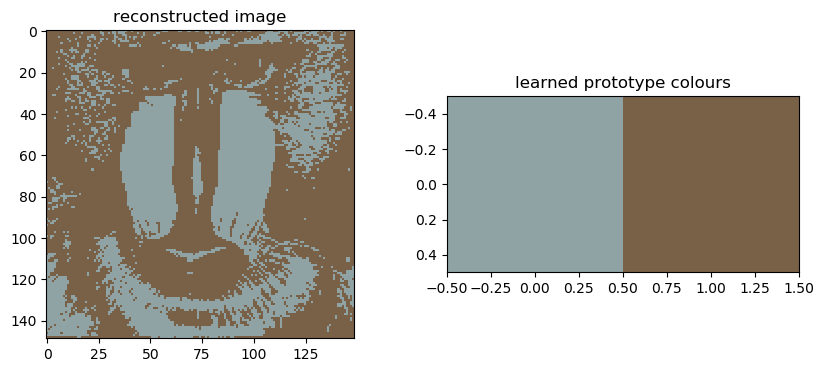

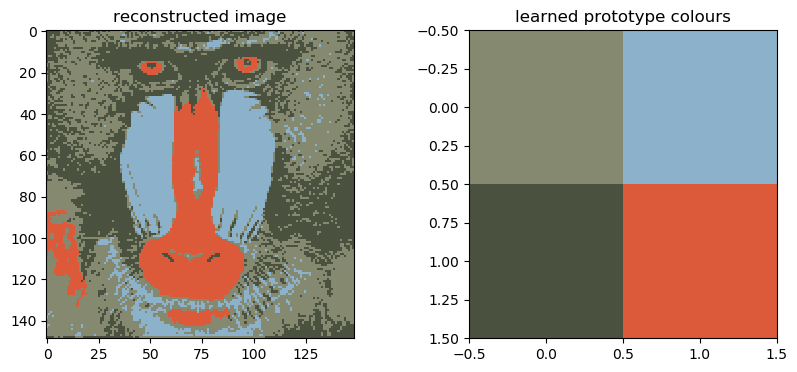

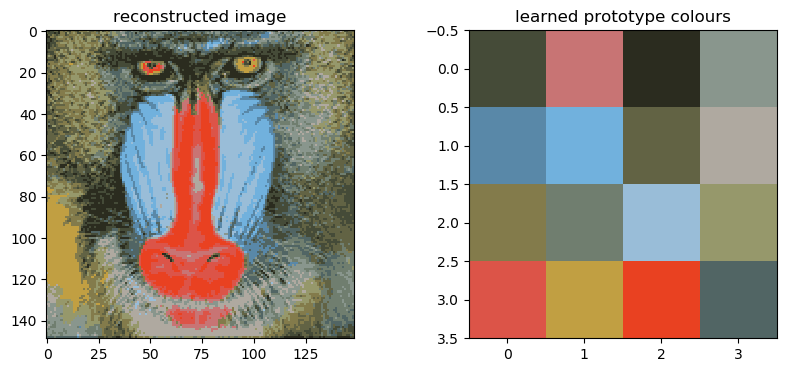

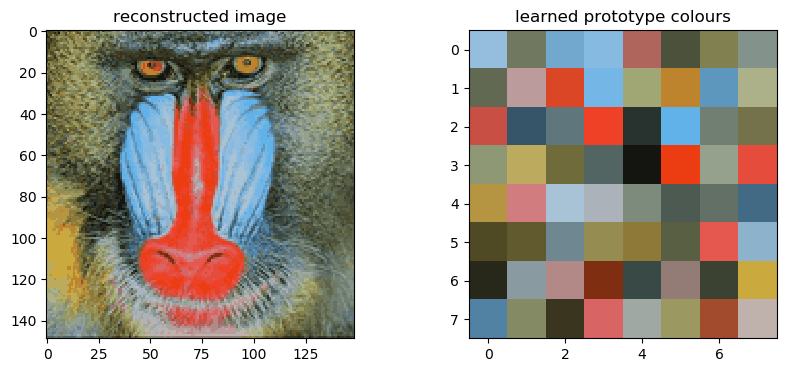

┌ Warning: Deprecated syntax `implicit assignment to global variable `bpp``.
│ Use `global bpp` instead.
└ @ nothing none:0
┌ Warning: Loop variable `bpp` around In[129]:1 overwrites a variable in an enclosing scope. In the future the variable will be local to the loop instead.
└ @ nothing In[129]:1


In [129]:
for bpp in [1,2,4,6]
    q_img, colours = quantize(img, bpp)
    d_img = dequantize(q_img, colours)
#     loss = np.sum((d_img - img)**2)/np.sum(img**2)*100
#     compression_ratio = bpp/8 # + colours
    plt.figure(figsize=(10,4));
    plt.subplot(1,2,1);
    plt.imshow(d_img);
    plt.title("reconstructed image")
    plt.subplot(1,2,2);
    plt.imshow(bpp/2!=div(bpp,2) ? reshape(colours,1,:,3) : reshape(colours, 2^div(bpp,2),2^div(bpp,2),3));
    plt.title("learned prototype colours")
end